In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
MAX_SEQUENCE_LENGTH = 5000
MAX_NUM_WORDS = 25000
EMBEDDING_DIM = 300
TEST_SPLIT = 0.2

TEXT_DATA = 'data/fake_or_real_news.csv'

In [3]:
# define a function that allows us to evaluate our models

from sklearn.metrics import accuracy_score

def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    '''
    evaluate the model, both training and testing errors are reported
    '''
    # training error
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train,y_predict_train)
    
    # testing error
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test,y_predict_test)
    
    return train_acc, test_acc

In [4]:
# estimate 95% confidence interval on error

# NOTE: based on conversation on stackexchange: 
# https://stats.stackexchange.com/questions/247551/how-to-determine-the-confidence-of-a-neural-network-prediction
# towards bottom of the page.

from math import sqrt

def error_conf(error, n):
    term = 1.96*sqrt((error*(1-error))/n)
    lb = error - term
    ub = error + term
    
    return lb, ub

In [5]:
# read in our data and preprocess it

df = pd.read_csv(TEXT_DATA)
df.drop(labels=['id','title'], axis='columns', inplace=True)
# only select stories with lengths gt 0 -- there are some texts with len = 0
mask = list(df['text'].apply(lambda x: len(x) > 0))
df = df[mask]

In [6]:
# prepare text samples and their labels

texts = df['text']
labels = df['label']

print('Found %s texts.' %texts.shape[0])

Found 6335 texts.


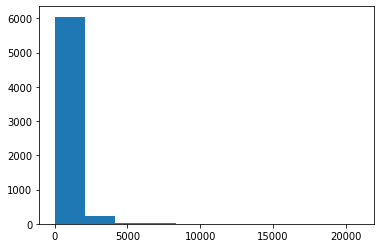

In [7]:
# plot the distribution of article lengths in terms of word counts

text_lengths = texts.apply(lambda x: len(x.split(" ")))
plt.hist(text_lengths)
plt.show()

## Naive Bayes

In [8]:
# set up vector models for training and testing

from sklearn.feature_extraction.text import CountVectorizer

# data vectorizer
vectorizer = CountVectorizer(analyzer = "word", 
                             binary = True, 
                             min_df = 2,
                             stop_words='english')
docarray = vectorizer.fit_transform(texts).toarray()
docterm = pd.DataFrame(docarray, columns=vectorizer.get_feature_names())

In [9]:
# create training and test data

from sklearn.model_selection import train_test_split
docterm_train, docterm_test, y_train, y_test = train_test_split(docterm, labels, test_size=TEST_SPLIT)

In [10]:
# Naive Bayes Model

from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(docterm_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [11]:
# evaluate model

train_acc, test_acc = evaluate_model(model.predict, docterm_train, y_train, docterm_test, y_test)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

Training Accuracy: 93.94%
Testing Accuracy: 89.98%


In [12]:
# estimate 95% confidence interval

n = docterm_test.shape[0]
lb, ub = error_conf(1-test_acc, n)

print("95% confidence interval: {:.2f}%-{:.2f}%".format((1-ub)*100,(1-lb)*100))

95% confidence interval: 88.32%-91.63%


# RBM and Naive Bayes

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.neural_network import BernoulliRBM

rbm= BernoulliRBM(random_state=0, verbose=True)
#RBM params
learning_rate = 0.03 # from Erhan et el. (2010): median value in grid-search
total_units   =  4000 
total_epochs  =   50 # from Erhan et el. (2010): optimal for MNIST
batch_size    =  256 # seems like a representative sample; backprop literature often uses 256 or 512 samples

rbm = BernoulliRBM(n_components=total_units, learning_rate=learning_rate, batch_size=batch_size, n_iter=total_epochs, verbose=1)

classifier = Pipeline(steps=[('rbm', rbm), ('Naive Bayes', model)])
classifier.fit(docterm_train, y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -1848.30, time = 143.70s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -9518.09, time = 160.47s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -6232.56, time = 156.87s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -3698.62, time = 156.60s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -1408.05, time = 157.43s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -3551.15, time = 156.60s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -11297.64, time = 155.76s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -3092.05, time = 156.41s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -3222.33, time = 157.14s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -2820.80, time = 156.69s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -3746.24, time = 157.12s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -20509.61, time = 156.80s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -1817.61, time = 157.17s
[BernoulliRBM] Iteration 14, pseudo-likelihoo

Pipeline(memory=None,
         steps=[('rbm',
                 BernoulliRBM(batch_size=256, learning_rate=0.03,
                              n_components=4000, n_iter=50, random_state=None,
                              verbose=1)),
                ('Naive Bayes',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

Old performance with only 1 epoch of Training with 5000 units of RBM:

In [16]:
train_acc, test_acc = evaluate_model(classifier.predict, docterm_train, y_train, docterm_test, y_test)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

Training Accuracy: 65.35%
Testing Accuracy: 63.77%


New performance with 50 epochs of training with 4000 units:

In [18]:
train_acc, test_acc = evaluate_model(classifier.predict, docterm_train, y_train, docterm_test, y_test)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

Training Accuracy: 75.06%
Testing Accuracy: 73.24%


In [24]:
# Save RBM:
import pickle

rbm_1 = classifier[0]
with open("RBM_4000unit_50ep_003learn.mdl", "wb") as handle:
    pickle.dump(rbm_1, handle)

#test:

with open("RBM_4000unit_50ep_003learn.mdl", "rb") as handle:
    rbm_test = pickle.load(handle)

In [29]:
#test1 (with saved model)
test_transformed_1 = rbm_1.transform(docterm_test)
train_acc, test_acc = evaluate_model(classifier[1].predict, test_transformed_1, y_test, test_transformed_1, y_test)
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

Training Accuracy: 73.24%
Testing Accuracy: 73.24%


In [30]:
# test 2 (with loaded model)
test_transformed_2 = rbm_test.transform(docterm_test)
train_acc, test_acc = evaluate_model(classifier[1].predict, test_transformed_2, y_test, test_transformed_1, y_test)
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

Training Accuracy: 73.24%
Testing Accuracy: 73.24%


## Simple Sigmoid NN

In [45]:
docterm_train.shape

(5068, 39271)

In [52]:
# build a simple Softmax/Sigmoid Classifier                                                                   

import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adadelta, Adam, RMSprop
from keras.utils import np_utils

np.random.seed(1337)
nb_classes = 2
batch_size = 128
nb_epochs = 10

y_train_2d = np_utils.to_categorical(y_train.apply(lambda x: 0 if x == "FAKE" else 1), 2)
y_test_2d = np_utils.to_categorical(y_test.apply(lambda x: 0 if x == "FAKE" else 1), 2)

In [53]:
# model

model = Sequential()
model.add(Dense(100, input_shape =(39271,)))
model.add(Activation("relu"))
model.add(Dropout(0.1))
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(nb_classes))
model.add(Activation("softmax"))
model.compile(loss = "categorical_crossentropy", optimizer = "adam")
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               3927200   
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1010      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 22        
_________________________________________________________________
activation_3 (Activation)    (None, 2)                

In [56]:
# train the model

history = model.fit(docterm_train.values, 
                    y_train_2d,
                    batch_size=128,
                    epochs=10,
                    validation_data=(docterm_test.values, y_test_2d))

Train on 5068 samples, validate on 1267 samples
Epoch 1/10
5068/5068 [==============================] - 5s 1ms/step - loss: 0.3680 - val_loss: 0.2051
Epoch 2/10
5068/5068 [==============================] - 4s 742us/step - loss: 0.0687 - val_loss: 0.1832
Epoch 3/10
5068/5068 [==============================] - 4s 732us/step - loss: 0.0273 - val_loss: 0.2024
Epoch 4/10
5068/5068 [==============================] - 4s 739us/step - loss: 0.0151 - val_loss: 0.2222
Epoch 5/10
5068/5068 [==============================] - 4s 767us/step - loss: 0.0091 - val_loss: 0.2464
Epoch 6/10
5068/5068 [==============================] - 4s 782us/step - loss: 0.0062 - val_loss: 0.2713
Epoch 7/10
5068/5068 [==============================] - 4s 780us/step - loss: 0.0044 - val_loss: 0.2950
Epoch 8/10
5068/5068 [==============================] - 4s 739us/step - loss: 0.0034 - val_loss: 0.3110
Epoch 9/10
5068/5068 [==============================] - 4s 739us/step - loss: 0.0026 - val_loss: 0.3482
Epoch 10/10
5068/5

In [60]:
# evaluate model

Y_train_predclass = model.predict_classes(docterm_train,batch_size=batch_size)
Y_test_predclass = model.predict_classes(docterm_test,batch_size=batch_size)

print(accuracy_score(y_train.apply(lambda x: 0 if x == "FAKE" else 1), Y_train_predclass))
print(accuracy_score(y_test.apply(lambda x: 0 if x == "FAKE" else 1), Y_test_predclass))

0.999802683504341
0.9321231254932912


In [62]:
# estimate 95% confidence interval

n = docterm_test.shape[0]
lb, ub = error_conf(1-0.9321231254932912, n)

print("95% confidence interval: {:.2f}%-{:.2f}%".format((1-ub)*100,(1-lb)*100))

95% confidence interval: 91.83%-94.60%


# Pipeline RBM and Sigmoid Classifier

In [63]:
# Wrap Classifier in Keras function

from keras.wrappers.scikit_learn import KerasClassifier

def create_keras_model():
    model = Sequential()
    model.add(Dense(100, input_shape =(39271,)))
    model.add(Activation("relu"))
    model.add(Dropout(0.1))
    model.add(Dense(10))
    model.add(Activation("relu"))
    model.add(Dense(nb_classes))
    model.add(Activation("softmax"))
    model.compile(loss = "categorical_crossentropy", optimizer = "adam")
    return model

keras_clf = KerasClassifier(build_fn=create_keras_model, verbose=0)

In [66]:
# model

model2 = Sequential()
model2.add(Dense(100, input_shape =(4000,)))
model2.add(Activation("relu"))
model2.add(Dropout(0.1))
model2.add(Dense(10))
model2.add(Activation("relu"))
model2.add(Dense(nb_classes))
model2.add(Activation("softmax"))
model2.compile(loss = "categorical_crossentropy", optimizer = "adam")
print(model2.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 100)               400100    
_________________________________________________________________
activation_4 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1010      
_________________________________________________________________
activation_5 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 22        
_________________________________________________________________
activation_6 (Activation)    (None, 2)                

In [67]:
transformed_train = rbm_test.transform(docterm_train)
history_2 = model2.fit(transformed_train, 
                    y_train_2d,
                    batch_size=128,
                    epochs=10,
                    validation_data=(test_transformed_2, y_test_2d))

Train on 5068 samples, validate on 1267 samples
Epoch 1/10
5068/5068 [==============================] - 1s 105us/step - loss: 0.7327 - val_loss: 0.6336
Epoch 2/10
5068/5068 [==============================] - 0s 75us/step - loss: 0.6077 - val_loss: 0.5514
Epoch 3/10
5068/5068 [==============================] - 0s 74us/step - loss: 0.5143 - val_loss: 0.4084
Epoch 4/10
5068/5068 [==============================] - 0s 74us/step - loss: 0.4143 - val_loss: 0.3783
Epoch 5/10
5068/5068 [==============================] - 0s 74us/step - loss: 0.3810 - val_loss: 0.4060
Epoch 6/10
5068/5068 [==============================] - 0s 74us/step - loss: 0.3734 - val_loss: 0.3994
Epoch 7/10
5068/5068 [==============================] - 0s 75us/step - loss: 0.3455 - val_loss: 0.3773
Epoch 8/10
5068/5068 [==============================] - 0s 75us/step - loss: 0.3352 - val_loss: 0.3672
Epoch 9/10
5068/5068 [==============================] - 0s 77us/step - loss: 0.3476 - val_loss: 0.3496
Epoch 10/10
5068/5068 [=

In [70]:
# evaluate model

Y_train_predclass = model2.predict_classes(transformed_train,batch_size=batch_size)
Y_test_predclass = model2.predict_classes(test_transformed_2,batch_size=batch_size)

print(accuracy_score(y_train.apply(lambda x: 0 if x == "FAKE" else 1), Y_train_predclass))
print(accuracy_score(y_test.apply(lambda x: 0 if x == "FAKE" else 1), Y_test_predclass))

0.8516179952644041
0.846093133385951


# Pipeline DBN

In [73]:
# DBN Architecture

learning_rate = 0.03 # from Erhan et el. (2010): median value in grid-search
batch_size    =  256  # seems like a representative sample; backprop literature often uses 256 or 512 samples

# RBM 1

total_units_1   =  26000 
total_epochs_1  =   65

# RBM 2
total_units_2 = 18000
total_epochs_2 = 50

# RBM 3
total_units_3 = 14000
total_epochs_3 = 45

# RBM 4
total_units_4 = 9000
total_epochs_4 = 40

# RBM 5
total_units_5 = 6000
total_epochs_5 = 40

# RBM 6
total_units_6   =  4000 
total_epochs_6  =   35 

rbm_1 = BernoulliRBM(n_components=total_units_1, learning_rate=learning_rate, batch_size=batch_size, n_iter=total_epochs_1, verbose=1)
rbm_2 = BernoulliRBM(n_components=total_units_2, learning_rate=learning_rate, batch_size=batch_size, n_iter=total_epochs_2, verbose=1)
rbm_3 = BernoulliRBM(n_components=total_units_3, learning_rate=learning_rate, batch_size=batch_size, n_iter=total_epochs_3, verbose=1)
rbm_4 = BernoulliRBM(n_components=total_units_4, learning_rate=learning_rate, batch_size=batch_size, n_iter=total_epochs_4, verbose=1)
rbm_5 = BernoulliRBM(n_components=total_units_5, learning_rate=learning_rate, batch_size=batch_size, n_iter=total_epochs_5, verbose=1)
rbm_6 = BernoulliRBM(n_components=total_units_6, learning_rate=learning_rate, batch_size=batch_size, n_iter=total_epochs_6, verbose=1)

DBN = Pipeline(steps=[('rbm_1', rbm_1), ('rbm_2', rbm_2), ('rbm_3', rbm_3), ('rbm_4', rbm_4), ('rbm_5', rbm_5), ('rbm_6', rbm_6)], verbose = True)


In [ ]:
# Fitting DBN
DBN.fit(docterm_train, y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -15881.58, time = 3112.96s


In [ ]:
#Save DBN
with open("DBN_26to4_6rbm.mdl", "wb") as handle:
    pickle.dump(DBN, handle)
    
#Save first rbm
with open("RBM_26_65epoch_1dbn.mdl", "wb") as handle:
    pickle.dump(DBN[0], handle)
    
#Save second rbm
with open("RBM_18_50epoch_2dbn.mdl", "wb") as handle:
    pickle.dump(DBN[1], handle)

#Save third rbm
with open("RBM_14_45epoch_3dbn.mdl", "wb") as handle:
    pickle.dump(DBN[2], handle)

#Save fourth rbm
with open("RBM_9_40epoch_4dbn.mdl", "wb") as handle:
    pickle.dump(DBN[3], handle)

#Save fifth rbm
with open("RBM_6_40epoch_5dbn.mdl", "wb") as handle:
    pickle.dump(DBN[4], handle)

#Save sixth rbm
with open("RBM_4_35epoch_6dbn.mdl", "wb") as handle:
    pickle.dump(DBN[5], handle)

# Pipeline DBN and Sigmoid Classifier